# Big Brother Brasil 26 - Reaction Analysis Dashboard

## Overview

This notebook analyzes **participant reaction data** from Big Brother Brasil 26 (BBB26), using data from the GloboPlay API. Participants react to each other daily using emoji-based reactions, which reveal social dynamics, alliances, and conflicts within the house.

### What are Reactions?

Every day, BBB participants can give reactions to other houseguests using emojis. These reactions fall into three categories:

| Category | Reactions | Meaning |
|----------|-----------|---------|
| **Positive** ❤️ | Coração (Heart) | Love, support, friendship |
| **Mild Negative** 💼🌱🍪 | Mala (Baggage), Planta (Plant), Biscoito (Cookie) | Annoying, invisible/boring, attention-seeking |
| **Strong Negative** 🐍🎯🤮🤥💔 | Cobra (Snake), Alvo (Target), Vômito (Vomit), Mentiroso (Liar), Coração Partido (Broken Heart) | Betrayal, enemy, disgust, dishonesty, disappointment |

### Key Metrics Analyzed

1. **Sentiment Score**: Net positivity (positive reactions minus weighted negatives)
2. **Controversy Score**: Product of positive and negative reactions (high = divisive)
3. **Balance Correlation**: Relationship between game balance (currency) and social standing
4. **Alliance Mapping**: Who supports whom, and mutual relationships

### Data Source

- **API**: `https://apis-globoplay.globo.com/mve-api/globo-play/realities/bbb/participants/`
- **Historical Data**: JSON snapshots saved with timestamps for timeline analysis

### ⚠️ Important: Daily vs Historical Data

**The API returns CUMULATIVE totals** (all reactions since season start), not daily increments.

| Analysis Type | Data Used | Description |
|--------------|-----------|------------|
| **Cumulative Analysis** | All-time totals | Main analysis report, cumulative cross tables, sentiment scores - shows total reactions accumulated |
| **Daily Analysis** | Changes since previous day | Daily cross tables - calculated by comparing current vs previous day's snapshot |
| **Timeline Analysis** | Multiple historical snapshots | Trend analysis using all saved JSON files to show changes over time |

**What's CUMULATIVE (Historical):**
- Main reaction analysis report
- Cumulative cross tables (emoji and numeric)
- Sentiment scores and metrics
- Relationship analysis
- Network graphs

**What's DAILY (Current Day Changes):**
- Daily cross tables (only if previous day data is available)
- Shows only new reactions added since last snapshot

---

## 1. Setup & Configuration

Import required libraries for data processing, analysis, and visualization.

In [1]:
# ============================================================================
# IMPORTS
# ============================================================================

import requests
import json
import pandas as pd
import numpy as np
import os
import glob
from datetime import datetime, timedelta
from collections import defaultdict

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import networkx as nx

# Set style for matplotlib
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('dark_background')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


---

## 2. Reaction Categorization

Define the sentiment categories for each reaction type. This categorization is crucial for all analysis.

### Why These Categories?

- **Positive**: Only the heart emoji represents genuine support
- **Mild Negative**: These suggest annoyance but not conflict
  - 🌱 Planta (Plant) = "You don't do anything, just blend in"
  - 💼 Mala (Baggage) = "You're annoying/a burden"
  - 🍪 Biscoito (Cookie) = "You're just seeking attention"
- **Strong Negative**: These indicate real conflict or betrayal
  - 🐍 Cobra (Snake) = "You're a backstabber"
  - 🎯 Alvo (Target) = "You're my target/enemy"
  - 🤮 Vômito (Vomit) = "I'm disgusted by you"
  - 🤥 Mentiroso (Liar) = "You're dishonest"
  - 💔 Coração Partido (Broken Heart) = "You disappointed me" 

In [2]:
# ============================================================================
# REACTION CATEGORIES & EMOJI MAPPING
# ============================================================================

# Emoji mapping for display
EMOJI_MAP = {
    'Coração': '❤️',
    'Coração partido': '💔',
    'Cobra': '🐍',
    'Mala': '💼',
    'Planta': '🌱',
    'Biscoito': '🍪',
    'Alvo': '🎯',
    'Vômito': '🤮',
    'Mentiroso': '🤥'
}

# Sentiment categories
POSITIVE_REACTIONS = ['Coração']
MILD_NEGATIVE_REACTIONS = ['Planta', 'Mala', 'Biscoito']
STRONG_NEGATIVE_REACTIONS = ['Cobra', 'Alvo', 'Vômito', 'Mentiroso', 'Coração partido']

# Sentiment weights for scoring
SENTIMENT_WEIGHTS = {
    'positive': 1.0,      # Full positive weight
    'mild_negative': -0.5,  # Half negative weight (less severe)
    'strong_negative': -1.0  # Full negative weight
}

def get_reaction_emoji(reaction_name):
    """Return emoji for a Portuguese reaction name"""
    return EMOJI_MAP.get(reaction_name, reaction_name)

def categorize_reaction(reaction_name):
    """Categorize a reaction into sentiment categories"""
    if reaction_name in POSITIVE_REACTIONS:
        return 'positive'
    elif reaction_name in MILD_NEGATIVE_REACTIONS:
        return 'mild_negative'
    elif reaction_name in STRONG_NEGATIVE_REACTIONS:
        return 'strong_negative'
    return 'unknown'

def get_sentiment_weight(reaction_name):
    """Get numerical sentiment weight for a reaction"""
    category = categorize_reaction(reaction_name)
    return SENTIMENT_WEIGHTS.get(category, 0)

print("✅ Reaction categories configured:")
print(f"   Positive: {[f'{r} {get_reaction_emoji(r)}' for r in POSITIVE_REACTIONS]}")
print(f"   Mild Negative: {[f'{r} {get_reaction_emoji(r)}' for r in MILD_NEGATIVE_REACTIONS]}")
print(f"   Strong Negative: {[f'{r} {get_reaction_emoji(r)}' for r in STRONG_NEGATIVE_REACTIONS]}")

✅ Reaction categories configured:
   Positive: ['Coração ❤️']
   Mild Negative: ['Planta 🌱', 'Mala 💼', 'Biscoito 🍪']
   Strong Negative: ['Cobra 🐍', 'Alvo 🎯', 'Vômito 🤮', 'Mentiroso 🤥', 'Coração partido 💔']


---

## 3. Data Collection

Functions to fetch data from the GloboPlay API and manage local backups.

### Data Flow

1. **Primary**: Fetch fresh data from API
2. **Backup**: Save timestamped JSON files locally  
3. **Fallback**: Load most recent local file if API fails

### Historical Data

Each run saves a new JSON file with timestamp, enabling timeline analysis of how reactions change over the season.

**Effective date (data day):** New results are published around noon. A capture **before noon** is treated as the **previous calendar day** (e.g., 2AM on Jan 24 → data from Jan 23). **Noon or after** → that calendar day. The file catalog deduplicates multiple same-day runs by keeping the latest capture per effective date.


In [3]:
# ============================================================================
# DATA COLLECTION FUNCTIONS
# ============================================================================

API_URL = "https://apis-globoplay.globo.com/mve-api/globo-play/realities/bbb/participants/"

# --- File catalog: effective date & deduplication ---
# New results published ~noon. Capture before noon = data from previous calendar day.
NOON_CUTOFF_HOUR = 12

def parse_bbb_filename(filename):
    """Parse bbb_participants_YYYY-MM-DD_HH-MM-SS.json -> (capture_date, time, effective_date, capture_dt)."""
    if not (filename.startswith('bbb_participants_') and filename.endswith('.json')):
        return None
    try:
        base = filename.replace('bbb_participants_', '').replace('.json', '')
        date_part, time_part = base.split('_')[0], base.split('_')[1]
        y, m, d = map(int, date_part.split('-'))
        h, mi, s = map(int, time_part.split('-'))
        capture_dt = datetime(y, m, d, h, mi, s)
        effective_dt = (capture_dt - timedelta(days=1)) if h < NOON_CUTOFF_HOUR else capture_dt
        return (date_part, time_part, effective_dt.strftime('%Y-%m-%d'), capture_dt)
    except Exception:
        return None

def catalog_bbb_files():
    """Catalog bbb_participants_*.json. Returns (df, by_effective, duplicates_list)."""
    files = sorted(glob.glob('bbb_participants_*.json'))
    rows = []
    for f in files:
        p = parse_bbb_filename(f)
        if p:
            date_part, time_part, eff, cap_dt = p
            rows.append({'file': f, 'capture_date': date_part, 'capture_time': time_part, 'capture_datetime': cap_dt, 'effective_date': eff})
    if not rows:
        return pd.DataFrame(), {}, []
    df = pd.DataFrame(rows)
    by_eff = {e: df[df['effective_date'] == e].sort_values('capture_datetime')['file'].tolist() for e in df['effective_date'].unique()}
    dups = [(e, L) for e, L in by_eff.items() if len(L) > 1]
    return df, by_eff, dups

def get_canonical_for_date(effective_date, by_effective=None):
    """Best file for effective_date (latest capture)."""
    if by_effective is None:
        _, by_effective, _ = catalog_bbb_files()
    L = by_effective.get(effective_date, [])
    return L[-1] if L else None

def get_previous_effective_date(effective_date, by_effective=None):
    """Effective date immediately before the given one."""
    if by_effective is None:
        _, by_effective, _ = catalog_bbb_files()
    dates = sorted(by_effective.keys())
    i = dates.index(effective_date) if effective_date in dates else -1
    return dates[i - 1] if i > 0 else None

def save_api_response(api_url=API_URL):
    """Fetch data from API and save with timestamp"""
    try:
        response = requests.get(api_url, timeout=10)
        response.raise_for_status()
        data = response.json()
        
        # Save with timestamp
        timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        filename = f"bbb_participants_{timestamp}.json"
        
        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(data, f, indent=2, ensure_ascii=False)
        
        print(f"✅ Data saved to {filename}")
        print(f"   Participants found: {len(data)}")
        return data
        
    except requests.RequestException as e:
        print(f"⚠️ API request failed: {e}")
        return None

def load_latest_saved_data():
    """Load the most recent saved JSON file as fallback. Uses effective date (before noon=previous day) and canonical file per day."""
    _, by_eff, _ = catalog_bbb_files()
    if not by_eff:
        print("❌ No saved data files found")
        return None
    latest_eff = max(by_eff.keys())
    latest_file = get_canonical_for_date(latest_eff, by_eff)
    print(f"📂 Loading: {latest_file} (effective date: {latest_eff})")
    with open(latest_file, 'r', encoding='utf-8') as f:
        data = json.load(f)
    print(f"   Participants loaded: {len(data)}")
    return data

def get_all_reaction_types(data):
    """Extract all unique reaction types from data"""
    reactions = set()
    for participant in data:
        received = participant.get('characteristics', {}).get('receivedReactions', [])
        for reaction in received:
            if label := reaction.get('label'):
                reactions.add(label)
    return sorted(reactions)

print("✅ Data collection functions ready")


✅ Data collection functions ready


In [ ]:
# ============================================================================
# FILE CATALOG REPORT
# ============================================================================
# Effective date: capture before noon => previous calendar day; noon+ => that day.
# Canonical file per effective date: latest capture. (Defs in Data Collection cell.)

df, by_eff, dups = catalog_bbb_files()
print("BBB participants file catalog")
print("  Effective date: before noon = previous calendar day; noon or after = that day.")
if df.empty:
    print("  No bbb_participants_*.json files found.")
else:
    print(f"  Total files: {len(df)}")
    print(f"  Unique effective dates: {len(by_eff)}")
    if dups:
        print(f"  Duplicates ({len(dups)} effective dates with multiple files):")
        for eff, flist in sorted(dups, key=lambda x: x[0]):
            canon = flist[-1]
            print(f"    {eff}: {len(flist)} files -> canonical: {canon}")
            for f in flist[:-1]:
                print(f"        (duplicate) {f}")
    print("  Table: capture_date, capture_time, effective_date, file")
    display(df[['capture_date','capture_time','effective_date','file']])


---

## 4. Data Processing

Transform raw API data into structured formats for analysis.

### Data Types

**Important**: The API returns **cumulative totals** (all reactions since the start of the season), not daily increments.

- **Historical/Cumulative Data**: Total reactions accumulated over time (what the API returns)
- **Daily Data**: Changes since the previous day (calculated by comparing current vs previous snapshot)

### Data Structures Created

1. **organized_data**: List of processed participant dictionaries (CUMULATIVE - all time totals)
2. **cross_table**: Pandas DataFrame showing reaction counts between all pairs (CUMULATIVE - all time totals)
3. **daily_cross_table**: Pandas DataFrame showing reactions added since previous day (DAILY - changes only)
4. **sentiment_matrix**: Numerical sentiment scores between participants (CUMULATIVE - all time totals)

In [4]:
# ============================================================================
# DATA PROCESSING FUNCTIONS
# ============================================================================

def process_participants(data, verbose=False):
    """Process raw API data into organized participant list
    
    Returns:
        List of dicts with participant info and their received reactions
    """
    if not data:
        print("❌ No data to process")
        return []

    organized_data = []

    for participant in data:
        chars = participant.get('characteristics', {})
        
        participant_data = {
            "name": participant.get('name', 'N/A'),
            "job": chars.get('job', 'N/A'),
            "group": chars.get('group', 'N/A'),        # Vip or Xepa
            "memberOf": chars.get('memberOf', 'N/A'),  # Camarote, Pipoca, Veterano
            "balance": chars.get('balance', 0),
            "eliminated": chars.get('eliminated', False),
            "roles": [role.get('label', 'N/A') for role in chars.get('roles', [])],
            "reactions": {},
            "total_reactions": 0,
            "duo_partner": (participant.get('duo') or {}).get('name', 'None')
        }

        # Process received reactions
        received_reactions = chars.get('receivedReactions', [])
        for reaction in received_reactions:
            label = reaction.get('label')
            amount = reaction.get('amount', 0)
            givers = [p.get('name') for p in reaction.get('participants', [])]
            
            participant_data['reactions'][label] = {
                'amount': amount,
                'givers': givers
            }
            participant_data['total_reactions'] += amount
        
        organized_data.append(participant_data)
        
        if verbose:
            print(f"{participant_data['name']}: {participant_data['total_reactions']} reactions")

    print(f"✅ Processed {len(organized_data)} participants")
    return organized_data

def create_cross_table(organized_data):
    """Create reaction matrix: who reacted to whom
    
    Returns:
        DataFrame with givers as rows, receivers as columns (counts)
    """
    # Get all unique names
    all_names = set()
    for p in organized_data:
        all_names.add(p['name'])
        for reaction_data in p['reactions'].values():
            all_names.update(reaction_data['givers'])
    
    all_names = sorted(all_names)
    
    # Initialize matrix
    matrix = pd.DataFrame(0, index=all_names, columns=all_names)
    
    # Fill in reactions
    for p in organized_data:
        receiver = p['name']
        for reaction_name, reaction_data in p['reactions'].items():
            for giver in reaction_data['givers']:
                if giver in matrix.index and receiver in matrix.columns:
                    matrix.loc[giver, receiver] += 1
    
    print(f"✅ Cross table created: {len(all_names)}x{len(all_names)}")
    return matrix

def load_previous_day_data(current_effective_date=None):
    """Load the previous data day's canonical file for comparison.
    Uses effective date: before noon = previous calendar day.
    current_effective_date: effective date (data day) of current run. If None, inferred from latest in catalog.
    """
    _, by_eff, _ = catalog_bbb_files()
    if not by_eff:
        return None
    if current_effective_date is None:
        current_effective_date = max(by_eff.keys())
    prev_eff = get_previous_effective_date(current_effective_date, by_eff)
    if not prev_eff:
        return None
    prev_file = get_canonical_for_date(prev_eff, by_eff)
    if not prev_file:
        return None
    print(f"📂 Previous day data found: {prev_file} (effective date: {prev_eff})")
    with open(prev_file, 'r', encoding='utf-8') as f:
        prev_data = json.load(f)
    return process_participants(prev_data, verbose=False)

def calculate_daily_changes(current_organized_data, previous_organized_data):
    """Calculate daily changes in reactions by comparing current vs previous data
    
    Returns:
        organized_data with daily changes (new reactions since previous day)
    """
    if previous_organized_data is None:
        print("⚠️ No previous day data available - cannot calculate daily changes")
        return None
    
    # Create lookup for previous data
    prev_lookup = {p['name']: p for p in previous_organized_data}
    
    daily_changes = []
    
    for current_p in current_organized_data:
        name = current_p['name']
        prev_p = prev_lookup.get(name)
        
        if prev_p is None:
            # New participant - all reactions are new
            daily_changes.append(current_p)
            continue
        
        # Calculate differences
        daily_p = {
            "name": name,
            "job": current_p.get('job', 'N/A'),
            "group": current_p.get('group', 'N/A'),
            "memberOf": current_p.get('memberOf', 'N/A'),
            "balance": current_p.get('balance', 0),
            "eliminated": current_p.get('eliminated', False),
            "roles": current_p.get('roles', []),
            "reactions": {},
            "total_reactions": 0,
            "duo_partner": current_p.get('duo_partner', 'None')
        }
        
        # Calculate reaction differences
        prev_reactions = prev_p.get('reactions', {})
        current_reactions = current_p.get('reactions', {})
        
        for reaction_name, current_data in current_reactions.items():
            current_amount = current_data.get('amount', 0)
            prev_amount = prev_reactions.get(reaction_name, {}).get('amount', 0)
            daily_amount = current_amount - prev_amount
            
            if daily_amount > 0:
                # Get givers from current data (we can't know which specific ones are new)
                # So we'll use all current givers (approximation)
                daily_p['reactions'][reaction_name] = {
                    'amount': daily_amount,
                    'givers': current_data.get('givers', [])
                }
                daily_p['total_reactions'] += daily_amount
        
        daily_changes.append(daily_p)
    
    total_daily = sum(p['total_reactions'] for p in daily_changes)
    print(f"✅ Daily changes calculated: {total_daily} new reactions since previous day")
    return daily_changes

def create_emoji_cross_table(organized_data):
    """Create emoji-based reaction matrix: who reacted to whom with emojis
    
    Returns:
        DataFrame with givers as rows, receivers as columns (emojis showing reaction types)
    """
    # Get all unique names
    all_names = set()
    for p in organized_data:
        all_names.add(p['name'])
        for reaction_data in p['reactions'].values():
            all_names.update(reaction_data['givers'])
    
    all_names = sorted(all_names)
    
    # Initialize matrix with empty strings
    matrix = pd.DataFrame('', index=all_names, columns=all_names)
    
    # Track reactions by type for each pair
    reaction_matrix = defaultdict(lambda: defaultdict(list))
    
    # Fill in reactions
    for p in organized_data:
        receiver = p['name']
        for reaction_name, reaction_data in p['reactions'].items():
            emoji = get_reaction_emoji(reaction_name)
            category = categorize_reaction(reaction_name)
            for giver in reaction_data['givers']:
                if giver in matrix.index and receiver in matrix.columns:
                    reaction_matrix[giver][receiver].append((emoji, category, reaction_name))
    
    # Fill matrix with emojis (prioritize: positive > strong_negative > mild_negative)
    for giver in all_names:
        for receiver in all_names:
            if giver == receiver:
                matrix.loc[giver, receiver] = '—'  # Diagonal
            elif giver in reaction_matrix and receiver in reaction_matrix[giver]:
                reactions = reaction_matrix[giver][receiver]
                # Count by category
                positive_count = sum(1 for _, cat, _ in reactions if cat == 'positive')
                strong_neg_count = sum(1 for _, cat, _ in reactions if cat == 'strong_negative')
                mild_neg_count = sum(1 for _, cat, _ in reactions if cat == 'mild_negative')
                
                # Show dominant reaction type, or combine if multiple types
                # If mixed (both positive and negative), show mixed indicator
                if positive_count > 0 and (strong_neg_count > 0 or mild_neg_count > 0):
                    # Mixed reactions - show combination
                    matrix.loc[giver, receiver] = '❤️⚡'  # Positive but also negative
                elif positive_count > 0:
                    matrix.loc[giver, receiver] = '❤️'
                elif strong_neg_count > 0:
                    # Show the most common strong negative emoji
                    strong_neg_emojis = [emoji for emoji, cat, _ in reactions if cat == 'strong_negative']
                    if strong_neg_emojis:
                        matrix.loc[giver, receiver] = strong_neg_emojis[0]  # Use first one
                elif mild_neg_count > 0:
                    # Show the most common mild negative emoji
                    mild_neg_emojis = [emoji for emoji, cat, _ in reactions if cat == 'mild_negative']
                    if mild_neg_emojis:
                        matrix.loc[giver, receiver] = mild_neg_emojis[0]  # Use first one
    
    print(f"✅ Emoji cross table created: {len(all_names)}x{len(all_names)}")
    return matrix

def get_dominant_reaction_emoji(organized_data, giver, receiver):
    """Get the dominant reaction emoji for a giver-receiver pair
    
    Returns the emoji of the reaction that the giver gave to the receiver.
    If multiple reactions exist, returns the one with highest amount.
    """
    for p in organized_data:
        if p['name'] == receiver:
            # Find all reactions where this giver is in the givers list
            giver_reactions = []
            for reaction_name, reaction_data in p.get('reactions', {}).items():
                givers = reaction_data.get('givers', [])
                if giver in givers:
                    # Count how many times this giver appears (could be multiple if same reaction given multiple times)
                    count = givers.count(giver)
                    giver_reactions.append((reaction_name, count))
            
            if giver_reactions:
                # Sort by count (most frequent first), then by reaction priority
                giver_reactions.sort(key=lambda x: (x[1], x[0]), reverse=True)
                dominant_reaction = giver_reactions[0][0]
                return get_reaction_emoji(dominant_reaction)
    return None

def create_transition_cross_table(current_organized_data, previous_organized_data):
    """Create cross table showing reaction transitions from previous day to current day
    
    Shows transitions like: 🎯->❤️ (changed from Alvo/Target to Heart/Positive)
    Compares dominant reaction type between previous and current day
    
    Returns:
        DataFrame with givers as rows, receivers as columns showing transitions
    """
    if previous_organized_data is None:
        return None
    
    # Get all unique names
    all_names = set()
    for p in current_organized_data:
        all_names.add(p['name'])
        for reaction_data in p.get('reactions', {}).values():
            all_names.update(reaction_data.get('givers', []))
    for p in previous_organized_data:
        all_names.add(p['name'])
        for reaction_data in p.get('reactions', {}).values():
            all_names.update(reaction_data.get('givers', []))
    
    all_names = sorted(all_names)
    
    # Initialize matrix
    matrix = pd.DataFrame('', index=all_names, columns=all_names)
    
    # Fill matrix with transitions
    for giver in all_names:
        for receiver in all_names:
            if giver == receiver:
                matrix.loc[giver, receiver] = '—'
            else:
                prev_emoji = get_dominant_reaction_emoji(previous_organized_data, giver, receiver)
                curr_emoji = get_dominant_reaction_emoji(current_organized_data, giver, receiver)
                
                if prev_emoji is None and curr_emoji is None:
                    # No reaction in either
                    continue
                elif prev_emoji is None and curr_emoji:
                    # New reaction
                    matrix.loc[giver, receiver] = f'NEW:{curr_emoji}'
                elif prev_emoji and curr_emoji is None:
                    # Removed reaction
                    matrix.loc[giver, receiver] = f'{prev_emoji}->X'
                elif prev_emoji and curr_emoji:
                    # Only show if the reaction changed
                    if prev_emoji != curr_emoji:
                        # Transition occurred - show the change
                        matrix.loc[giver, receiver] = f'{prev_emoji}->{curr_emoji}'
                    # If same, skip (don't show unchanged reactions)
    
    print(f"✅ Transition cross table created: {len(all_names)}x{len(all_names)}")
    return matrix

def create_sentiment_matrix(organized_data):
    """Create weighted sentiment matrix
    
    Positive reactions = +1, Mild negative = -0.5, Strong negative = -1
    """
    all_names = sorted(set(p['name'] for p in organized_data))
    matrix = pd.DataFrame(0.0, index=all_names, columns=all_names)
    
    for p in organized_data:
        receiver = p['name']
        for reaction_name, reaction_data in p['reactions'].items():
            weight = get_sentiment_weight(reaction_name)
            for giver in reaction_data['givers']:
                if giver in matrix.index:
                    matrix.loc[giver, receiver] += weight
    
    return matrix

print("✅ Data processing functions ready")


✅ Data processing functions ready


---

## 5. Analysis Functions

Calculate metrics and generate insights from the reaction data.

### Key Metrics

| Metric | Formula | Meaning | Range |
|--------|---------|---------|-------|
| **Sentiment Score** | positive - 0.5×mild - 1×strong | Net positivity received | Typically ranges from **+20 to -20** (or higher/lower depending on total reactions). Positive values indicate more positive reactions, negative values indicate more negative reactions. |
| **Controversy Score** | positive × (mild + strong) | How divisive someone is | Higher values indicate someone receives both positive AND negative reactions (divisive). Zero means no controversy (all positive or all negative). |
| **Positive %** | positive / total × 100 | % of reactions that are positive | 0% to 100%. Higher = more loved, lower = more targeted. |

**Understanding Sentiment Score Values:**
- **High positive (e.g., +15 to +20)**: Very well-liked, receives mostly positive reactions
- **Moderate positive (e.g., +5 to +15)**: Generally liked, more positive than negative
- **Near zero (e.g., -2 to +2)**: Mixed reactions, balanced or neutral
- **Moderate negative (e.g., -5 to -15)**: Generally disliked, more negative than positive  
- **High negative (e.g., -15 to -20)**: Very disliked, receives mostly negative reactions

In [5]:
# ============================================================================
# ANALYSIS FUNCTIONS
# ============================================================================

def analyze_reactions(organized_data):
    """Calculate reaction statistics for each participant"""
    analysis = {}
    
    for p in organized_data:
        name = p['name']
        total = p.get('total_reactions', 0)
        
        positive = 0
        mild_negative = 0
        strong_negative = 0
        
        for reaction_name, data in p['reactions'].items():
            amount = data.get('amount', 0)
            category = categorize_reaction(reaction_name)
            
            if category == 'positive':
                positive += amount
            elif category == 'mild_negative':
                mild_negative += amount
            elif category == 'strong_negative':
                strong_negative += amount
        
        # Calculate metrics
        sentiment = positive - 0.5*mild_negative - strong_negative
        controversy = positive * (mild_negative + strong_negative)
        
        analysis[name] = {
            'total': total,
            'positive': positive,
            'mild_negative': mild_negative,
            'strong_negative': strong_negative,
            'positive_pct': (positive / total * 100) if total > 0 else 0,
            'sentiment_score': sentiment,
            'controversy_score': controversy,
            'balance': p.get('balance', 0),
            'group': p.get('group', 'N/A'),
            'memberOf': p.get('memberOf', 'N/A')
        }
    
    return analysis

def find_alliances_and_enemies(organized_data):
    """Identify mutual relationships between participants"""
    sentiment_given = defaultdict(lambda: defaultdict(float))
    
    for p in organized_data:
        receiver = p['name']
        for reaction_name, data in p['reactions'].items():
            weight = get_sentiment_weight(reaction_name)
            for giver in data['givers']:
                sentiment_given[giver][receiver] += weight
    
    # Find mutual relationships
    relationships = []
    names = sorted(set(p['name'] for p in organized_data))
    checked = set()
    
    for p1 in names:
        for p2 in names:
            if p1 < p2 and (p1, p2) not in checked:
                checked.add((p1, p2))
                s1_to_2 = sentiment_given[p1].get(p2, 0)
                s2_to_1 = sentiment_given[p2].get(p1, 0)
                
                if s1_to_2 != 0 or s2_to_1 != 0:
                    if s1_to_2 > 0 and s2_to_1 > 0:
                        rel_type = 'Allies'
                    elif s1_to_2 < 0 and s2_to_1 < 0:
                        rel_type = 'Enemies'
                    else:
                        rel_type = 'Mixed'
                    
                    relationships.append({
                        'person1': p1,
                        'person2': p2,
                        'p1_to_p2': s1_to_2,
                        'p2_to_p1': s2_to_1,
                        'mutual_sentiment': s1_to_2 + s2_to_1,
                        'relationship': rel_type
                    })
    
    return pd.DataFrame(relationships)

def print_analysis_report(analysis):
    """Print comprehensive analysis report with detailed table and insights"""
    df = pd.DataFrame(analysis).T

    # Coerce numeric columns (JSON sources may store numbers as strings)
    numeric_cols = [
        'total',
        'positive',
        'mild_negative',
        'strong_negative',
        'positive_pct',
        'sentiment_score',
        'controversy_score',
        'balance',
    ]
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Ensure controversy_score is numeric and handle any remaining issues
    if 'controversy_score' in df.columns:
        df['controversy_score'] = pd.to_numeric(df['controversy_score'], errors='coerce').fillna(0)

    # Calculate additional metrics for insights
    df['negative_pct'] = ((df['mild_negative'] + df['strong_negative']) / df['total'] * 100).fillna(0)
    df['really_bad_pct'] = (df['strong_negative'] / df['total'] * 100).fillna(0)
    # Weighted negative score: really_bad * 2 + mid_bad
    df['weighted_negative'] = df['strong_negative'] * 2 + df['mild_negative']
    df['weighted_negative_pct'] = (df['weighted_negative'] / df['total'] * 100).fillna(0)
    # Balance score: how close positive and negative are to 50% (between 35-65%)
    df['balance_score'] = df.apply(
        lambda row: abs(row['positive_pct'] - 50) if 35 <= row['positive_pct'] <= 65 and 35 <= row['negative_pct'] <= 65 else 100,
        axis=1
    )
    
    print("\n" + "="*80)
    print("REACTION ANALYSIS - Big Brother Brasil")
    print("="*80)
    print("📊 DATA TYPE: CUMULATIVE (All-time totals since season start)")
    
    print("\nCategories:")
    print("  ❤️  Positive: Coração (Heart)")
    print("  ⚠️  Mid-Bad: Planta (Plant - not playing), Mala (Suitcase - annoying), Biscoito (Cookie - attention-seeking)")
    print("  🔴  Really Bad: Cobra (Snake - betrayal), Alvo (Target - targeting), Vômito (Vomit - disgust),")
    print("                 Mentiroso (Liar - deception), Coração partido (Broken Heart - disappointment)")
    print("\n  Note: 'Most Negative' calculation weights really_bad reactions 2x more than mid_bad reactions.")
    print("        'Most Balanced' requires both positive and negative percentages between 35-65%.")
    
    print("\n" + "-"*80)
    print(f"\nTotal Participants: {len(df)}")
    print("\nParticipant               Positive             Mid-Bad              Really Bad          ")
    print("-"*80)
    
    # Sort by name for the table
    df_sorted = df.sort_index()
    for name in df_sorted.index:
        data = analysis[name]
        pos_pct = data['positive_pct']
        pos_count = int(data['positive'])
        mid_pct = (data['mild_negative'] / data['total'] * 100) if data['total'] > 0 else 0
        mid_count = int(data['mild_negative'])
        bad_pct = (data['strong_negative'] / data['total'] * 100) if data['total'] > 0 else 0
        bad_count = int(data['strong_negative'])
        
        print(f"{name:23} ❤️  {pos_pct:5.1f}% ({pos_count:2})  ⚠️  {mid_pct:5.1f}% ({mid_count:2})  🔴  {bad_pct:5.1f}% ({bad_count:2})")
    
    print(f"\n(Displayed {len(df)} participants)")
    
    # Key Insights
    print("\n" + "="*80)
    print("KEY INSIGHTS")
    print("="*80)
    
    # TOP 3 MOST POSITIVE
    top_positive = df.nlargest(3, 'positive_pct')
    print("\n❤️ TOP 3 MOST POSITIVE:")
    for idx, (name, row) in enumerate(top_positive.iterrows(), 1):
        print(f"   {idx}. {name} ({row['positive_pct']:.1f}% - {int(row['positive'])} reactions)")
    
    # TOP 3 MOST NEGATIVE (sorted by total negative percentage, but weighted calculation mentioned in note)
    top_negative = df.nlargest(3, 'negative_pct')
    print("\n🔴 TOP 3 MOST NEGATIVE:")
    for idx, (name, row) in enumerate(top_negative.iterrows(), 1):
        total_neg = int(row['mild_negative'] + row['strong_negative'])
        neg_pct = row['negative_pct']
        print(f"   {idx}. {name} ({neg_pct:.1f}% - {total_neg} reactions)")
    
    # TOP 3 MOST REALLY BAD
    top_really_bad = df.nlargest(3, 'really_bad_pct')
    print("\n🔴 TOP 3 MOST REALLY BAD:")
    for idx, (name, row) in enumerate(top_really_bad.iterrows(), 1):
        print(f"   {idx}. {name} ({row['really_bad_pct']:.1f}% - {int(row['strong_negative'])} reactions)")
    
    # TOP 3 MOST BALANCED
    balanced = df[df['balance_score'] < 100].nsmallest(3, 'balance_score')
    if len(balanced) > 0:
        print("\n⚖️ TOP 3 MOST BALANCED:")
        for idx, (name, row) in enumerate(balanced.iterrows(), 1):
            neg_pct = row['negative_pct']
            balance_diff = abs(row['positive_pct'] - 50)
            print(f"   {idx}. {name} ({row['positive_pct']:.1f}% positive, {neg_pct:.1f}% negative, balance: {balance_diff:.1f}%)")
    else:
        print("\n⚖️ TOP 3 MOST BALANCED:")
        print("   (No participants meet the balanced criteria of 35-65% for both positive and negative)")
    
    # Overall Statistics
    total_reactions = df['total'].sum()
    total_positive = df['positive'].sum()
    total_mid_bad = df['mild_negative'].sum()
    total_really_bad = df['strong_negative'].sum()
    
    print("\n📊  Overall Statistics:")
    print(f"   Total Reactions: {int(total_reactions)}")
    print(f"   ❤️  Positive: {int(total_positive)} ({total_positive/total_reactions*100:.1f}%)")
    print(f"   ⚠️  Mid-Bad: {int(total_mid_bad)} ({total_mid_bad/total_reactions*100:.1f}%)")
    print(f"   🔴  Really Bad: {int(total_really_bad)} ({total_really_bad/total_reactions*100:.1f}%)")
    
    return df

print("✅ Analysis functions ready")

✅ Analysis functions ready


---

## 6. Visualizations

Create charts and graphs to visualize reaction patterns.

### Visualizations Generated

1. **Sentiment Heatmap**: Color-coded matrix of who likes/dislikes whom
2. **Balance Correlation**: Scatter plot of game balance vs sentiment
3. **Timeline Analysis**: How reactions change over time (using historical data)
4. **Network Graph**: Visual network of relationships
5. **Analysis Dashboard**: Multi-panel summary charts

In [6]:
# ============================================================================
# VISUALIZATION FUNCTIONS
# ============================================================================

def create_sentiment_heatmap(organized_data, figsize=(14, 12)):
    """Create heatmap showing sentiment between all participants"""
    sentiment_matrix = create_sentiment_matrix(organized_data)
    
    plt.figure(figsize=figsize)
    
    # Create custom colormap (red for negative, white for neutral, green for positive)
    cmap = sns.diverging_palette(10, 130, as_cmap=True)
    
    sns.heatmap(
        sentiment_matrix,
        annot=True,
        fmt='.1f',
        cmap=cmap,
        center=0,
        linewidths=0.5,
        square=True,
        cbar_kws={'label': 'Sentiment (+ = positive, - = negative)'}
    )
    
    plt.title('Reaction Sentiment Matrix\n(Rows = Giver, Columns = Receiver)', fontsize=14)
    plt.xlabel('Received Reactions From')
    plt.ylabel('Gave Reactions To')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    # Save
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"reaction_heatmap_{timestamp}.png"
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    print(f"📊 Saved: {filename}")
    
    plt.show()

def create_balance_correlation(organized_data, analysis):
    """Scatter plot: Game balance vs Sentiment score"""
    data = []
    for p in organized_data:
        name = p['name']
        if name in analysis:
            data.append({
                'name': name,
                'balance': p.get('balance', 0),
                'sentiment': analysis[name]['sentiment_score'],
                'group': p.get('group', 'Unknown'),
                'type': p.get('memberOf', 'Unknown')
            })
    
    df = pd.DataFrame(data)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot by group (Vip/Xepa)
    colors_group = {'Vip': '#FFD700', 'Xepa': '#87CEEB'}
    for group in df['group'].unique():
        mask = df['group'] == group
        axes[0].scatter(
            df[mask]['balance'], 
            df[mask]['sentiment'],
            c=colors_group.get(group, 'gray'),
            label=group,
            s=100,
            alpha=0.7
        )
    
    # Add labels
    for _, row in df.iterrows():
        axes[0].annotate(
            row['name'].split()[0],  # First name only
            (row['balance'], row['sentiment']),
            fontsize=8,
            alpha=0.7
        )
    
    axes[0].set_xlabel('Game Balance (BBBs)')
    axes[0].set_ylabel('Sentiment Score')
    axes[0].set_title('Balance vs Sentiment by Group')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot by type (Camarote/Pipoca/Veterano)
    colors_type = {'Camarote': '#9B59B6', 'Pipoca': '#E74C3C', 'Veterano': '#2ECC71'}
    for ptype in df['type'].unique():
        mask = df['type'] == ptype
        axes[1].scatter(
            df[mask]['balance'], 
            df[mask]['sentiment'],
            c=colors_type.get(ptype, 'gray'),
            label=ptype,
            s=100,
            alpha=0.7
        )
    
    for _, row in df.iterrows():
        axes[1].annotate(
            row['name'].split()[0],
            (row['balance'], row['sentiment']),
            fontsize=8,
            alpha=0.7
        )
    
    axes[1].set_xlabel('Game Balance (BBBs)')
    axes[1].set_ylabel('Sentiment Score')
    axes[1].set_title('Balance vs Sentiment by Type')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"balance_correlation_{timestamp}.png"
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    print(f"📊 Saved: {filename}")
    
    plt.show()
    
    # Calculate correlation
    corr = df['balance'].corr(df['sentiment'])
    print(f"\n📈 Correlation (Balance vs Sentiment): {corr:.3f}")

print("✅ Visualization functions ready")

✅ Visualization functions ready


### 📈 How to Interpret: Balance vs Sentiment Plot

The **Balance vs Sentiment** scatter plots show the relationship between a participant's game performance and their public perception.

#### Understanding the Axes

- **X-axis (Game Balance - BBBs)**: 
  - Represents accumulated financial/resource standing in the game
  - **Higher values (right)**: Better game balance (more money, advantages)
  - **Lower values (left)**: Poorer game balance (fewer resources)

- **Y-axis (Sentiment Score)**:
  - Overall sentiment from reactions received
  - **Higher positive values (up)**: More positive perception (well-liked)
    - Scores like +15 to +20 = Very well-liked
    - Scores like +5 to +15 = Generally liked
  - **Lower/negative values (down)**: More negative perception (disliked)
    - Scores like -5 to -15 = Generally disliked
    - Scores like -15 to -20 = Very disliked
  - **Near zero (-2 to +2)**: Mixed/neutral reactions

#### Quadrant Interpretation

- **Top-Right (High Balance, High Sentiment)**: Doing well in game AND well-regarded
- **Top-Left (Low Balance, High Sentiment)**: Well-liked despite lower game resources
- **Bottom-Right (High Balance, Low Sentiment)**: Good game performance but disliked
- **Bottom-Left (Low Balance, Low Sentiment)**: Struggling in game AND disliked

#### Group/Type Analysis

- **Left Plot (by Group)**: Compare Vip vs Xepa groups
  - Yellow = Vip members
  - Light Blue = Xepa members
- **Right Plot (by Type)**: Compare participant backgrounds
  - Purple = Camarote (Celebrity)
  - Red = Pipoca (Regular/Newcomer)
  - Green = Veterano (Veteran)

**Key Insight**: A positive correlation (upward trend) suggests better game balance tends to align with higher sentiment, but outliers reveal interesting exceptions.

In [7]:
def create_reaction_network(organized_data, min_sentiment=0.5):
    """Create network graph of relationships"""
    import networkx as nx
    
    sentiment_matrix = create_sentiment_matrix(organized_data)
    
    G = nx.DiGraph()
    
    # Add nodes
    for p in organized_data:
        G.add_node(p['name'], 
                   group=p.get('group', 'Unknown'),
                   balance=p.get('balance', 0))
    
    # Add edges for significant relationships
    for giver in sentiment_matrix.index:
        for receiver in sentiment_matrix.columns:
            if giver != receiver:
                sentiment = sentiment_matrix.loc[giver, receiver]
                if abs(sentiment) >= min_sentiment:
                    G.add_edge(giver, receiver, 
                              weight=abs(sentiment),
                              sentiment=sentiment)
    
    plt.figure(figsize=(16, 12))
    
    # Position nodes
    pos = nx.spring_layout(G, k=2, iterations=50, seed=42)
    
    # Color nodes by group
    node_colors = ['#FFD700' if G.nodes[n].get('group') == 'Vip' else '#87CEEB' 
                   for n in G.nodes()]
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, 
                           node_size=1500, alpha=0.8)
    nx.draw_networkx_labels(G, pos, font_size=8)
    
    # Draw edges - green for positive, red for negative
    positive_edges = [(u, v) for u, v, d in G.edges(data=True) if d['sentiment'] > 0]
    negative_edges = [(u, v) for u, v, d in G.edges(data=True) if d['sentiment'] < 0]
    
    nx.draw_networkx_edges(G, pos, edgelist=positive_edges,
                           edge_color='green', alpha=0.5, 
                           arrows=True, arrowsize=15)
    nx.draw_networkx_edges(G, pos, edgelist=negative_edges,
                           edge_color='red', alpha=0.5, 
                           arrows=True, arrowsize=15)
    
    plt.title('Reaction Network\n(Green = Positive, Red = Negative)', fontsize=14)
    plt.axis('off')
    
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"reaction_network_{timestamp}.png"
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    print(f"📊 Saved: {filename}")
    
    plt.show()

def analyze_reaction_timeline():
    """Analyze how reactions change over time using saved JSON files
    
    Shows positive, mild negative, and strong negative reactions over time
    """
    _, by_eff, _ = catalog_bbb_files()
    if len(by_eff) < 2:
        print("⚠️ Need at least 2 effective data days for timeline analysis")
        return
    
    # One canonical file per effective date (deduplicated; before noon = previous day)
    daily_files = {eff: get_canonical_for_date(eff, by_eff) for eff in by_eff}
    
    print(f"📅 Found {len(daily_files)} unique effective days of data")
    
    timeline_data = []
    
    for date, filepath in sorted(daily_files.items()):
        with open(filepath, 'r') as f:
            data = json.load(f)
        
        for p in data:
            name = p['name']
            chars = p.get('characteristics', {})
            received = chars.get('receivedReactions', [])
            
            # Separate by reaction categories
            positive = sum(r['amount'] for r in received if r['label'] in POSITIVE_REACTIONS)
            mild_negative = sum(r['amount'] for r in received if r['label'] in MILD_NEGATIVE_REACTIONS)
            strong_negative = sum(r['amount'] for r in received if r['label'] in STRONG_NEGATIVE_REACTIONS)
            total = positive + mild_negative + strong_negative
            
            timeline_data.append({
                'date': date,
                'name': name,
                'positive': positive,
                'mild_negative': mild_negative,
                'strong_negative': strong_negative,
                'total': total,
                'positive_pct': (positive / total * 100) if total > 0 else 0,
                'mild_negative_pct': (mild_negative / total * 100) if total > 0 else 0,
                'strong_negative_pct': (strong_negative / total * 100) if total > 0 else 0
            })
    
    df = pd.DataFrame(timeline_data)
    
    # Get top participants by positive percentage (most loved)
    latest_analysis = df[df['date'] == max(df['date'])]
    top_5_positive = latest_analysis.nlargest(5, 'positive_pct')['name'].tolist()
    
    # Get participants with most strong negative reactions (really bad)
    top_5_strong_neg = latest_analysis.nlargest(5, 'strong_negative_pct')['name'].tolist()
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Plot 1: Most Positive (Good reactions)
    for name in top_5_positive:
        person_data = df[df['name'] == name].sort_values('date')
        axes[0].plot(person_data['date'], person_data['positive_pct'], 
                    marker='o', label=name, linewidth=2)
    
    axes[0].set_title('Positive Reactions Over Time - Most Loved', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Positive Reaction %', fontsize=12)
    axes[0].set_xlabel('Date', fontsize=12)
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim(bottom=0)
    
    # Plot 2: Strong Negative Reactions (Really Bad)
    for name in top_5_strong_neg:
        person_data = df[df['name'] == name].sort_values('date')
        axes[1].plot(person_data['date'], person_data['strong_negative_pct'], 
                    marker='s', label=name, linewidth=2, linestyle='--')
    
    axes[1].set_title('Strong Negative Reactions Over Time - Most Targeted (Really Bad)', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Strong Negative Reaction %', fontsize=12)
    axes[1].set_xlabel('Date', fontsize=12)
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(True, alpha=0.3)
    axes[1].set_ylim(bottom=0)
    
    plt.tight_layout()
    
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"reaction_timeline_{timestamp}.png"
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    print(f"📊 Saved: {filename}")
    
    plt.show()

print("✅ Additional visualization functions ready")


✅ Additional visualization functions ready


---

## 7. Main Execution

Run the complete analysis pipeline.

📥 LOADING DATA
✅ Data saved to bbb_participants_2026-01-24_15-52-39.json
   Participants found: 22

📅 Data Date: 2026-01-24
📊 Data Source: API (fresh)
ℹ️  Note: API returns CUMULATIVE totals (all-time), not daily increments

🎭 REACTION TYPES FOUND
  🎯 Alvo → strong_negative
  🍪 Biscoito → mild_negative
  🐍 Cobra → strong_negative
  ❤️ Coração → positive
  💔 Coração partido → strong_negative
  💼 Mala → mild_negative
  🤥 Mentiroso → strong_negative
  🌱 Planta → mild_negative
  🤮 Vômito → strong_negative

⚙️ PROCESSING DATA (CUMULATIVE - All Time Totals)
✅ Processed 22 participants
✅ Cross table created: 22x22
✅ Emoji cross table created: 22x22

📅 CALCULATING DAILY CHANGES
📂 Previous day data found: bbb_participants_2026-01-23_15-48-49.json (date: 2026-01-23)
✅ Processed 22 participants
✅ Daily changes calculated: 57 new reactions since previous day

📊 Creating TRANSITION cross table (showing reaction changes: 🎯->❤️)...
✅ Transition cross table created: 22x22

📊 Creating DAILY cross table

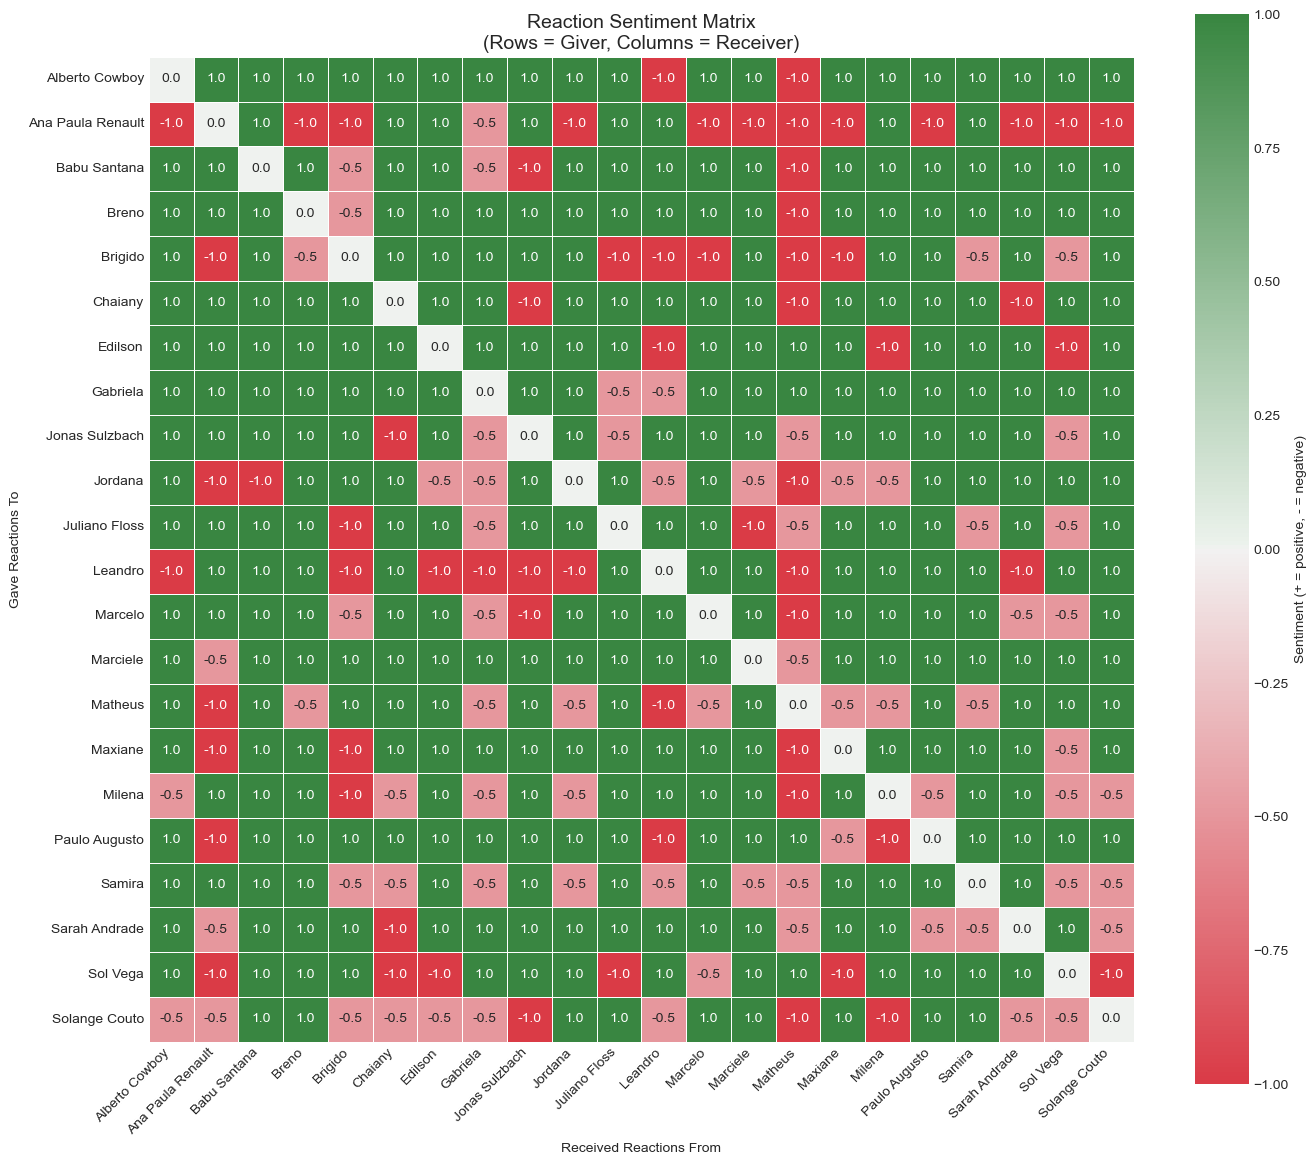

📊 Saved: balance_correlation_2026-01-24_15-52-40.png


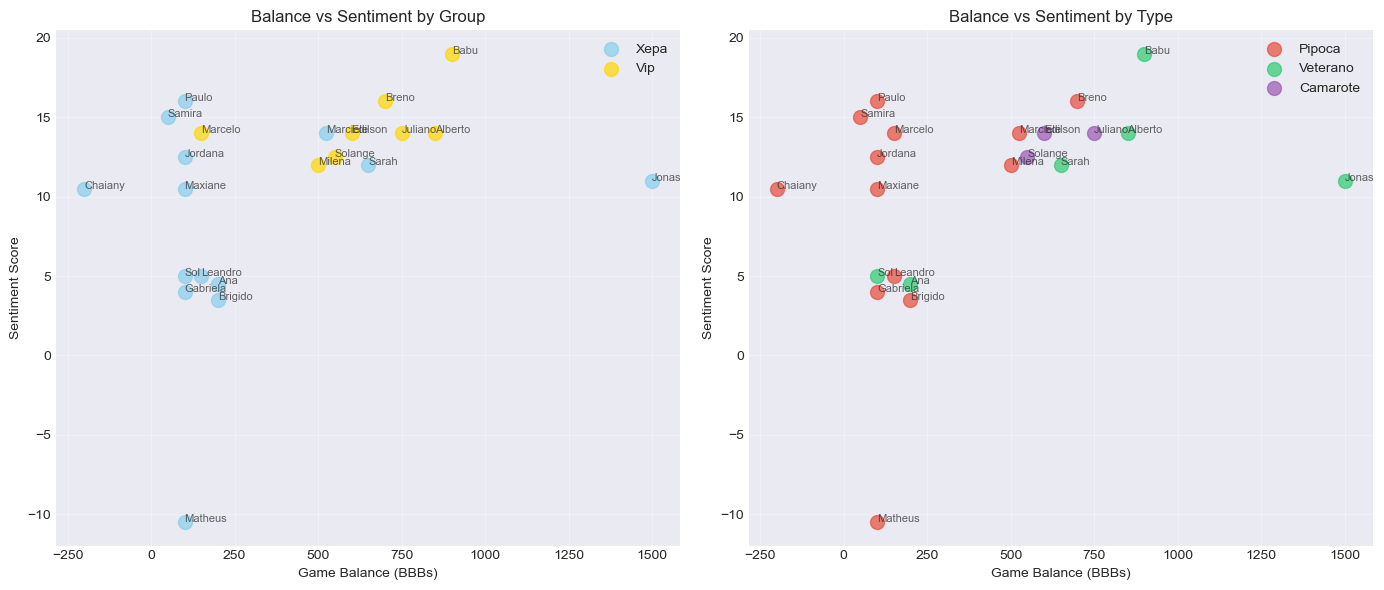


📈 Correlation (Balance vs Sentiment): 0.386
📊 Saved: reaction_network_2026-01-24_15-52-41.png


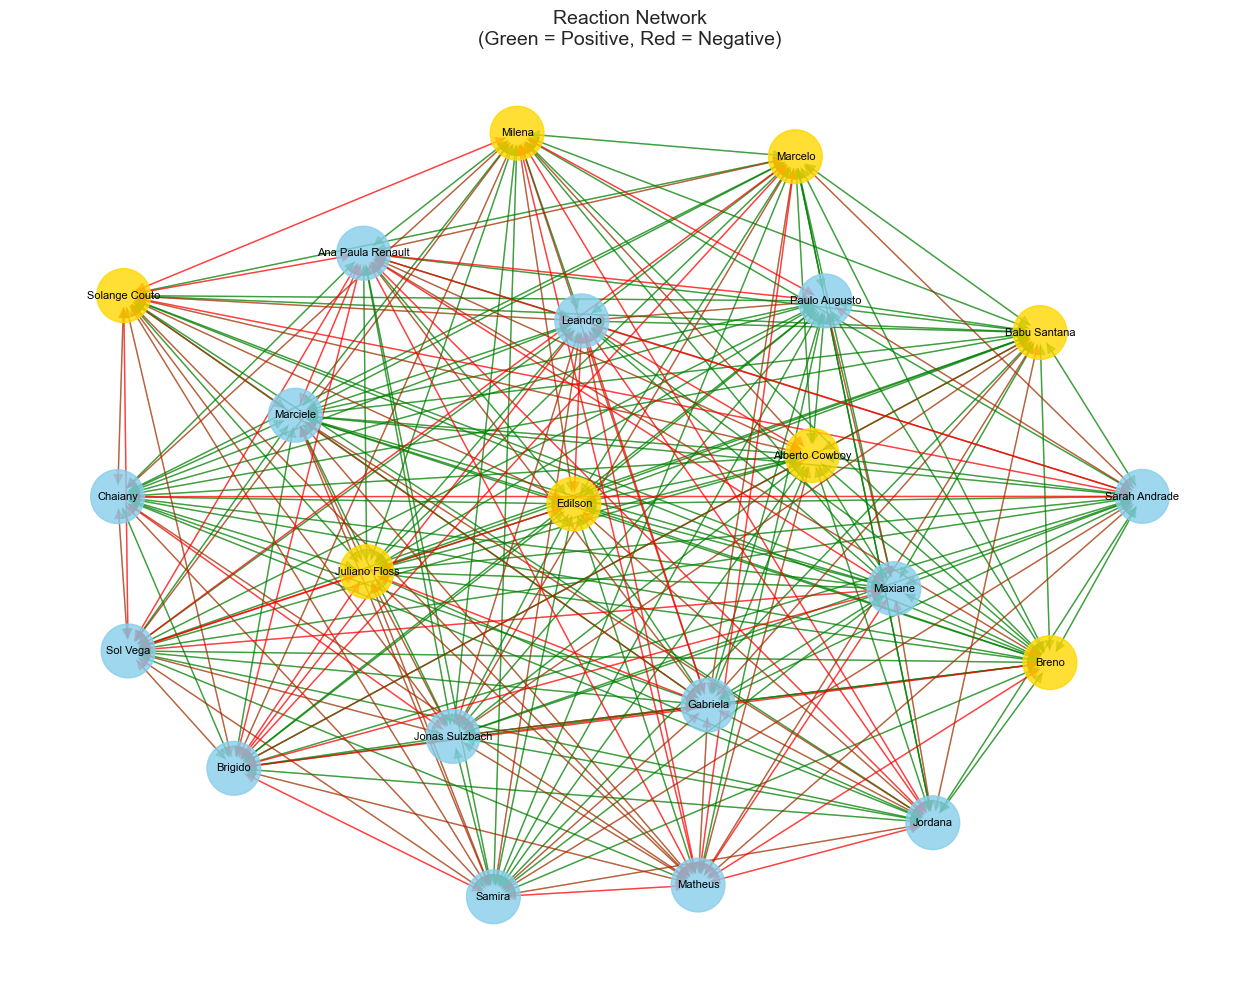

📅 Found 11 unique days of data
📊 Saved: reaction_timeline_2026-01-24_15-52-42.png


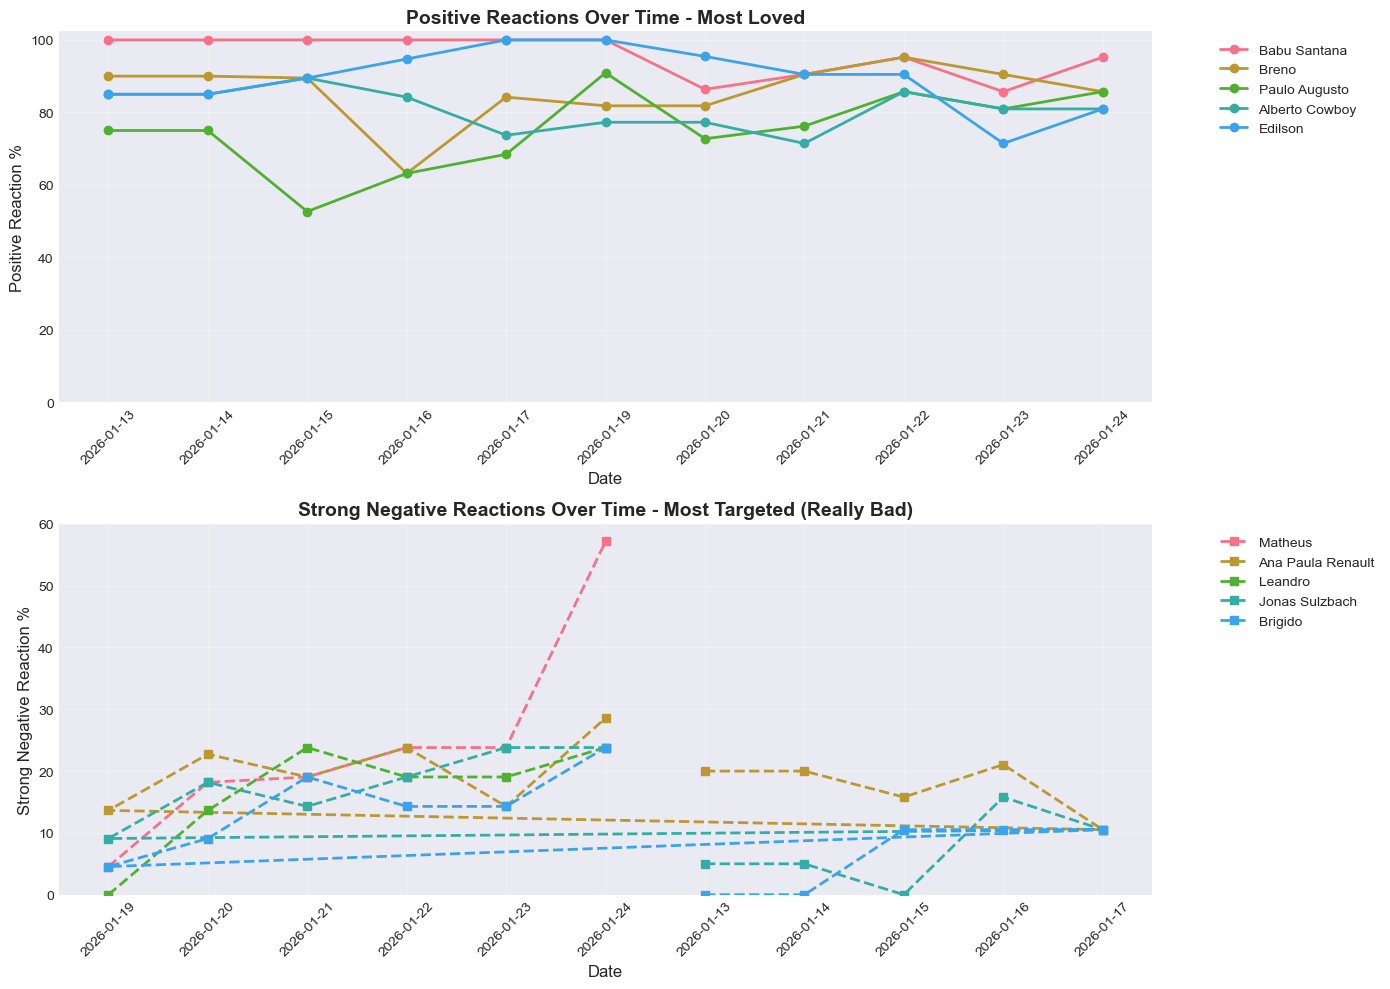


✅ ANALYSIS COMPLETE


In [8]:
# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    """Main analysis pipeline"""
    
    # 1. Fetch or load data
    print("="*70)
    print("📥 LOADING DATA")
    print("="*70)
    
    data = save_api_response()
    data_source = "API (fresh)"
    now = datetime.now()
    current_date = (now - timedelta(days=1)).strftime("%Y-%m-%d") if now.hour < 12 else now.strftime("%Y-%m-%d")  # effective: before noon=previous day
    
    if not data:
        print("\n⚠️ API failed, using saved data...")
        data = load_latest_saved_data()
        data_source = "Saved file (historical)"
        _, _by_eff, _ = catalog_bbb_files()
        if _by_eff:
            current_date = max(_by_eff.keys())  # effective date of latest canonical file
    
    if not data:
        print("❌ No data available")
        return
    
    print(f"\n📅 Data Date: {current_date}")
    print(f"📊 Data Source: {data_source}")
    print(f"ℹ️  Note: API returns CUMULATIVE totals (all-time), not daily increments")
    
    # 2. Show reaction types
    print("\n" + "="*70)
    print("🎭 REACTION TYPES FOUND")
    print("="*70)
    for reaction in get_all_reaction_types(data):
        emoji = get_reaction_emoji(reaction)
        category = categorize_reaction(reaction)
        print(f"  {emoji} {reaction} → {category}")
    
    # 3. Process data (CUMULATIVE - all time totals)
    print("\n" + "="*70)
    print("⚙️ PROCESSING DATA (CUMULATIVE - All Time Totals)")
    print("="*70)
    organized_data = process_participants(data)
    cross_table = create_cross_table(organized_data)
    emoji_cross_table = create_emoji_cross_table(organized_data)
    
    # 3b. Calculate daily changes
    print("\n" + "="*70)
    print("📅 CALCULATING DAILY CHANGES")
    print("="*70)
    previous_organized_data = load_previous_day_data(current_date)
    daily_organized_data = calculate_daily_changes(organized_data, previous_organized_data)
    
    daily_cross_table = None
    daily_emoji_cross_table = None
    transition_cross_table = None
    
    if previous_organized_data and organized_data:
        print("\n📊 Creating TRANSITION cross table (showing reaction changes: 🎯->❤️)...")
        transition_cross_table = create_transition_cross_table(organized_data, previous_organized_data)
    
    if daily_organized_data:
        print("\n📊 Creating DAILY cross tables (changes since previous day)...")
        daily_cross_table = create_cross_table(daily_organized_data)
        daily_emoji_cross_table = create_emoji_cross_table(daily_organized_data)
    else:
        print("⚠️ Daily cross tables not available (need previous day data)")
    
    # 4. Analysis
    print("\n" + "="*70)
    print("🔍 RUNNING ANALYSIS")
    print("="*70)
    analysis = analyze_reactions(organized_data)
    df_analysis = print_analysis_report(analysis)
    
    # 5. Find relationships
    print("\n" + "="*70)
    print("🤝 RELATIONSHIP ANALYSIS")
    print("="*70)
    relationships = find_alliances_and_enemies(organized_data)
    
    if not relationships.empty:
        print("\nTop Mutual Allies:")
        allies = relationships[relationships['relationship'] == 'Allies'].nlargest(10, 'mutual_sentiment')
        for _, row in allies.iterrows():
            print(f"  ❤️ {row['person1']} <-> {row['person2']}: {row['mutual_sentiment']:.1f}")
        
        print("\nTop Mutual Enemies:")
        enemies = relationships[relationships['relationship'] == 'Enemies'].nsmallest(5, 'mutual_sentiment')
        for _, row in enemies.iterrows():
            print(f"  ⚔️ {row['person1']} <-> {row['person2']}: {row['mutual_sentiment']:.1f}")
    
    # 6. Visualizations
    print("\n" + "="*70)
    print("📊 CREATING VISUALIZATIONS")
    print("="*70)
    
    create_sentiment_heatmap(organized_data)
    create_balance_correlation(organized_data, analysis)
    create_reaction_network(organized_data)
    analyze_reaction_timeline()
    
    print("\n" + "="*70)
    print("✅ ANALYSIS COMPLETE")
    print("="*70)
    
    return organized_data, analysis, cross_table, emoji_cross_table, daily_cross_table, daily_emoji_cross_table, transition_cross_table, relationships

# Run the analysis
organized_data, analysis, cross_table, emoji_cross_table, daily_cross_table, daily_emoji_cross_table, transition_cross_table, relationships = main()


---

## 8. Cross Table View

Display the full reaction cross-table showing all participant interactions.

In [9]:
# Display CUMULATIVE cross tables (all-time totals)
print("\n" + "="*80)
print("📋 CUMULATIVE REACTION CROSS TABLE (All-Time Totals)")
print("="*80)
print("Rows = Who gave reactions, Columns = Who received them")
print("Legend: ❤️ = Positive, 🐍🎯🤮🤥💔 = Strong Negative, 🌱💼🍪 = Mild Negative, — = Self, ⚡ = Mixed")
print("Note: Shows ALL reactions accumulated since season start")
print("-"*80)
display(emoji_cross_table)

# Display TRANSITION cross table (showing reaction changes: 🎯->❤️)
if transition_cross_table is not None:
    print("\n" + "="*80)
    print("🔄 REACTION TRANSITIONS (Previous Day → Current Day)")
    print("="*80)
    print("Rows = Who gave reactions, Columns = Who received them")
    print("Format: PREVIOUS->CURRENT (e.g., 🎯->❤️ means changed from Alvo/Target to Heart/Positive)")
    print("Legend: ❤️ = Positive, 🐍🎯🤮🤥💔 = Strong Negative, 🌱💼🍪 = Mild Negative, — = Self, X = Removed, NEW: = New")
    print("Note: Shows how reactions CHANGED between previous day and current day")
    print("-"*80)
    display(transition_cross_table)
elif daily_emoji_cross_table is not None:
    print("\n" + "="*80)
    print("📅 DAILY REACTION CROSS TABLE (New Reactions Only)")
    print("="*80)
    print("Rows = Who gave reactions, Columns = Who received them")
    print("Legend: ❤️ = Positive, 🐍🎯🤮🤥💔 = Strong Negative, 🌱💼🍪 = Mild Negative, — = Self, ⚡ = Mixed")
    print("Note: Shows ONLY new reactions added since the previous day's snapshot")
    print("-"*80)
    display(daily_emoji_cross_table)
else:
    print("\n" + "="*80)
    print("📅 DAILY REACTION CROSS TABLE")
    print("="*80)
    print("⚠️ Daily/Transition cross table not available - need previous day's data for comparison")
    print("   (This is normal for the first run or if previous day data is missing)")

# Save cross tables to CSV for reference
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
csv_filename_cumulative = f"reaction_cross_table_cumulative_{timestamp}.csv"
cross_table.to_csv(csv_filename_cumulative)
print(f"\n💾 Cumulative numeric cross table saved to: {csv_filename_cumulative}")

if daily_cross_table is not None:
    csv_filename_daily = f"reaction_cross_table_daily_{timestamp}.csv"
    daily_cross_table.to_csv(csv_filename_daily)
    print(f"💾 Daily numeric cross table saved to: {csv_filename_daily}")


📋 CUMULATIVE REACTION CROSS TABLE (All-Time Totals)
Rows = Who gave reactions, Columns = Who received them
Legend: ❤️ = Positive, 🐍🎯🤮🤥💔 = Strong Negative, 🌱💼🍪 = Mild Negative, — = Self, ⚡ = Mixed
Note: Shows ALL reactions accumulated since season start
--------------------------------------------------------------------------------


,Alberto Cowboy,Ana Paula Renault,Babu Santana,Breno,Brigido,Chaiany,Edilson,Gabriela,Jonas Sulzbach,Jordana,...,Marcelo,Marciele,Matheus,Maxiane,Milena,Paulo Augusto,Samira,Sarah Andrade,Sol Vega,Solange Couto
Alberto Cowboy,—,❤️,❤️,❤️,❤️,❤️,❤️,❤️,❤️,❤️,...,❤️,❤️,💔,❤️,❤️,❤️,❤️,❤️,❤️,❤️
Ana Paula Renault,🐍,—,❤️,🤥,🎯,❤️,❤️,🍪,❤️,🎯,...,💔,🎯,🎯,🎯,❤️,🎯,❤️,🎯,🎯,🎯
Babu Santana,❤️,❤️,—,❤️,💼,❤️,❤️,🍪,🤥,❤️,...,❤️,❤️,💔,❤️,❤️,❤️,❤️,❤️,❤️,❤️
Breno,❤️,❤️,❤️,—,💼,❤️,❤️,❤️,❤️,❤️,...,❤️,❤️,🐍,❤️,❤️,❤️,❤️,❤️,❤️,❤️
Brigido,❤️,🤮,❤️,💼,—,❤️,❤️,❤️,❤️,❤️,...,🐍,❤️,🤮,🐍,❤️,❤️,🌱,❤️,🌱,❤️
Chaiany,❤️,❤️,❤️,❤️,❤️,—,❤️,❤️,🎯,❤️,...,❤️,❤️,💔,❤️,❤️,❤️,❤️,🐍,❤️,❤️
Edilson,❤️,❤️,❤️,❤️,❤️,❤️,—,❤️,❤️,❤️,...,❤️,❤️,❤️,❤️,🐍,❤️,❤️,❤️,🎯,❤️
Gabriela,❤️,❤️,❤️,❤️,❤️,❤️,❤️,—,❤️,❤️,...,❤️,❤️,❤️,❤️,❤️,❤️,❤️,❤️,❤️,❤️
Jonas Sulzbach,❤️,❤️,❤️,❤️,❤️,🎯,❤️,💼,—,❤️,...,❤️,❤️,💼,❤️,❤️,❤️,❤️,❤️,🍪,❤️
Jordana,❤️,🤥,💔,❤️,❤️,❤️,🌱,💼,❤️,—,...,❤️,🌱,🤮,💼,💼,❤️,❤️,❤️,❤️,❤️



🔄 REACTION TRANSITIONS (Previous Day → Current Day)
Rows = Who gave reactions, Columns = Who received them
Format: PREVIOUS->CURRENT (e.g., 🎯->❤️ means changed from Alvo/Target to Heart/Positive)
Legend: ❤️ = Positive, 🐍🎯🤮🤥💔 = Strong Negative, 🌱💼🍪 = Mild Negative, — = Self, X = Removed, NEW: = New
Note: Shows how reactions CHANGED between previous day and current day
--------------------------------------------------------------------------------


,Alberto Cowboy,Ana Paula Renault,Babu Santana,Breno,Brigido,Chaiany,Edilson,Gabriela,Jonas Sulzbach,Jordana,...,Marcelo,Marciele,Matheus,Maxiane,Milena,Paulo Augusto,Samira,Sarah Andrade,Sol Vega,Solange Couto
Alberto Cowboy,—,,,,,,,,,,...,,,❤️->💔,,,,,,,
Ana Paula Renault,,—,,❤️->🤥,,,,,🎯->❤️,,...,❤️->💔,❤️->🎯,🐍->🎯,❤️->🎯,,,,,,
Babu Santana,,,—,,,,,💼->🍪,,,...,,,❤️->💔,,,,,,,
Breno,,,,—,,,,,,,...,,,,,,,,,,
Brigido,,🐍->🤮,,🤥->💼,—,,,🍪->❤️,,,...,🤥->🐍,,💼->🤮,❤️->🐍,💼->❤️,,,,,
Chaiany,,,,,,—,,,,,...,,,❤️->💔,,,,,🎯->🐍,,
Edilson,,,,,,,—,,,,...,,,,,❤️->🐍,,,,🐍->🎯,
Gabriela,,,,,,,,—,,,...,,,,,,,,,,
Jonas Sulzbach,,,,,,,,,—,,...,,,,,,,,,,🌱->❤️
Jordana,,💼->🤥,,,,,,🍪->💼,,—,...,,,💼->🤮,,🐍->💼,,,,,



💾 Cumulative numeric cross table saved to: reaction_cross_table_cumulative_2026-01-24_15-52-42.csv
💾 Daily numeric cross table saved to: reaction_cross_table_daily_2026-01-24_15-52-42.csv
